# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


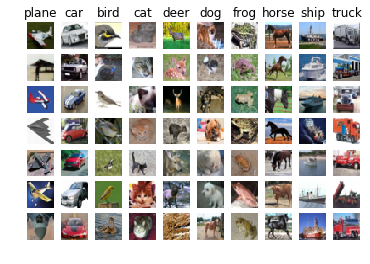

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


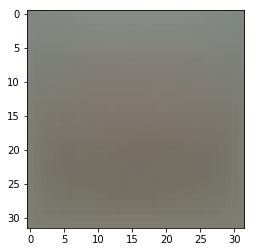

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [9]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.494354


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [10]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
# f = lambda w: svm_loss_vectorized(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
# f = lambda w: svm_loss_vectorized(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -29.500630 analytic: -29.500630, relative error: 2.124791e-11
numerical: 4.226269 analytic: 4.226269, relative error: 3.516624e-11
numerical: 22.764996 analytic: 22.764996, relative error: 1.001744e-11
numerical: -15.578972 analytic: -15.578972, relative error: 9.241428e-12
numerical: -5.780211 analytic: -5.780211, relative error: 9.393304e-11
numerical: -0.004282 analytic: -0.004282, relative error: 3.484420e-09
numerical: -20.830152 analytic: -20.789161, relative error: 9.849075e-04
numerical: -1.394766 analytic: -1.394766, relative error: 1.643836e-10
numerical: 41.288162 analytic: 41.288162, relative error: 4.490610e-12
numerical: 10.793520 analytic: 10.793520, relative error: 1.620261e-11
numerical: 8.052540 analytic: 8.052540, relative error: 4.371603e-11
numerical: 29.485349 analytic: 29.485349, relative error: 5.113449e-12
numerical: 0.699680 analytic: 0.699680, relative error: 5.519366e-10
numerical: -34.030814 analytic: -33.967749, relative error: 9.274450e-04
nume

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *fill this in.*

In [11]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.

tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 2.5e4)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 2.5e4)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 1.730902e+01 computed in 0.251149s
Vectorized loss: 1.730902e+01 computed in 0.011487s
difference: 0.000000


In [12]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.
from cs231n.classifiers.linear_svm import svm_loss_vectorized

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 2.5e4)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 2.5e4)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.186709s
Vectorized loss and gradient: computed in 0.010107s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [13]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers.linear_svm import svm_loss_naive
import time
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 799.463493
iteration 100 / 1500: loss 290.923499
iteration 200 / 1500: loss 108.943607
iteration 300 / 1500: loss 43.053411
iteration 400 / 1500: loss 19.207094
iteration 500 / 1500: loss 10.344557
iteration 600 / 1500: loss 7.232693
iteration 700 / 1500: loss 5.837831
iteration 800 / 1500: loss 5.696749
iteration 900 / 1500: loss 5.492313
iteration 1000 / 1500: loss 5.565429
iteration 1100 / 1500: loss 5.696885
iteration 1200 / 1500: loss 5.530258
iteration 1300 / 1500: loss 5.571372
iteration 1400 / 1500: loss 4.632854
That took 6.578980s


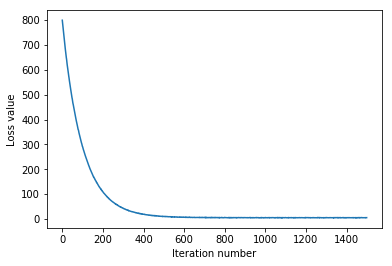

In [14]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [15]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.370551
validation accuracy: 0.383000


In [16]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-8, 5e-8, 1e-7, 5e-7, 1e-6, 5e-6, 1e-7, 5e-7]
regularization_strengths = [5, 10]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train, y_train, learning_rate=lr, reg=reg,
                      batch_size=32, num_iters=10000, verbose=True)
        y_train_pred = svm.predict(X_train)
        y_val_pred = svm.predict(X_val)
        training_accuracy, validation_accuracy = np.mean(y_train_pred == y_train), np.mean(y_val_pred==y_val)
        if validation_accuracy > best_val:
            best_val = validation_accuracy
            best_svm = svm
        results[(lr, reg)] = (training_accuracy, validation_accuracy)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 10000: loss 15.388879
iteration 100 / 10000: loss 16.435981
iteration 200 / 10000: loss 14.993070
iteration 300 / 10000: loss 13.698149
iteration 400 / 10000: loss 10.928258
iteration 500 / 10000: loss 15.761996
iteration 600 / 10000: loss 13.517461
iteration 700 / 10000: loss 14.504341
iteration 800 / 10000: loss 9.877118
iteration 900 / 10000: loss 16.312866
iteration 1000 / 10000: loss 12.767015
iteration 1100 / 10000: loss 6.996770
iteration 1200 / 10000: loss 10.620236
iteration 1300 / 10000: loss 10.784609
iteration 1400 / 10000: loss 9.858751
iteration 1500 / 10000: loss 10.105678
iteration 1600 / 10000: loss 8.630820
iteration 1700 / 10000: loss 9.259263
iteration 1800 / 10000: loss 6.929054
iteration 1900 / 10000: loss 11.245638
iteration 2000 / 10000: loss 10.441289
iteration 2100 / 10000: loss 7.444687
iteration 2200 / 10000: loss 10.277217
iteration 2300 / 10000: loss 11.582093
iteration 2400 / 10000: loss 7.705563
iteration 2500 / 10000: loss 10.132451
iterat

iteration 1700 / 10000: loss 9.559617
iteration 1800 / 10000: loss 5.838811
iteration 1900 / 10000: loss 7.116900
iteration 2000 / 10000: loss 9.785709
iteration 2100 / 10000: loss 8.241412
iteration 2200 / 10000: loss 6.917607
iteration 2300 / 10000: loss 8.416518
iteration 2400 / 10000: loss 5.861337
iteration 2500 / 10000: loss 9.837829
iteration 2600 / 10000: loss 6.652954
iteration 2700 / 10000: loss 4.407512
iteration 2800 / 10000: loss 7.169439
iteration 2900 / 10000: loss 6.268072
iteration 3000 / 10000: loss 7.841069
iteration 3100 / 10000: loss 5.643420
iteration 3200 / 10000: loss 7.360228
iteration 3300 / 10000: loss 7.242734
iteration 3400 / 10000: loss 6.209115
iteration 3500 / 10000: loss 6.254636
iteration 3600 / 10000: loss 7.867327
iteration 3700 / 10000: loss 5.469027
iteration 3800 / 10000: loss 5.170393
iteration 3900 / 10000: loss 5.545388
iteration 4000 / 10000: loss 6.926094
iteration 4100 / 10000: loss 7.242117
iteration 4200 / 10000: loss 4.195786
iteration 43

iteration 3300 / 10000: loss 8.479067
iteration 3400 / 10000: loss 6.404800
iteration 3500 / 10000: loss 7.834329
iteration 3600 / 10000: loss 8.017806
iteration 3700 / 10000: loss 5.136948
iteration 3800 / 10000: loss 5.733602
iteration 3900 / 10000: loss 5.643507
iteration 4000 / 10000: loss 5.834589
iteration 4100 / 10000: loss 5.200032
iteration 4200 / 10000: loss 7.421327
iteration 4300 / 10000: loss 5.291274
iteration 4400 / 10000: loss 4.912347
iteration 4500 / 10000: loss 6.445414
iteration 4600 / 10000: loss 5.760742
iteration 4700 / 10000: loss 4.584854
iteration 4800 / 10000: loss 3.539110
iteration 4900 / 10000: loss 5.518964
iteration 5000 / 10000: loss 6.439030
iteration 5100 / 10000: loss 4.886582
iteration 5200 / 10000: loss 6.706444
iteration 5300 / 10000: loss 7.255774
iteration 5400 / 10000: loss 7.668264
iteration 5500 / 10000: loss 4.640962
iteration 5600 / 10000: loss 5.246806
iteration 5700 / 10000: loss 5.958242
iteration 5800 / 10000: loss 5.927426
iteration 59

iteration 5100 / 10000: loss 5.515922
iteration 5200 / 10000: loss 6.437704
iteration 5300 / 10000: loss 3.918216
iteration 5400 / 10000: loss 6.565265
iteration 5500 / 10000: loss 2.533169
iteration 5600 / 10000: loss 4.097816
iteration 5700 / 10000: loss 6.391647
iteration 5800 / 10000: loss 4.061772
iteration 5900 / 10000: loss 6.528790
iteration 6000 / 10000: loss 4.555564
iteration 6100 / 10000: loss 4.916727
iteration 6200 / 10000: loss 6.609900
iteration 6300 / 10000: loss 4.246068
iteration 6400 / 10000: loss 7.492634
iteration 6500 / 10000: loss 3.752769
iteration 6600 / 10000: loss 4.019884
iteration 6700 / 10000: loss 3.864816
iteration 6800 / 10000: loss 8.693560
iteration 6900 / 10000: loss 7.510636
iteration 7000 / 10000: loss 4.043055
iteration 7100 / 10000: loss 4.279910
iteration 7200 / 10000: loss 5.383171
iteration 7300 / 10000: loss 6.413169
iteration 7400 / 10000: loss 6.836409
iteration 7500 / 10000: loss 5.139956
iteration 7600 / 10000: loss 4.330501
iteration 77

iteration 6900 / 10000: loss 10.376662
iteration 7000 / 10000: loss 5.304058
iteration 7100 / 10000: loss 10.791461
iteration 7200 / 10000: loss 7.379902
iteration 7300 / 10000: loss 6.629031
iteration 7400 / 10000: loss 5.909822
iteration 7500 / 10000: loss 5.828086
iteration 7600 / 10000: loss 5.609150
iteration 7700 / 10000: loss 6.461237
iteration 7800 / 10000: loss 9.252539
iteration 7900 / 10000: loss 8.131881
iteration 8000 / 10000: loss 6.959077
iteration 8100 / 10000: loss 6.780810
iteration 8200 / 10000: loss 6.888465
iteration 8300 / 10000: loss 8.162792
iteration 8400 / 10000: loss 5.839673
iteration 8500 / 10000: loss 5.309457
iteration 8600 / 10000: loss 6.248950
iteration 8700 / 10000: loss 4.604217
iteration 8800 / 10000: loss 9.331200
iteration 8900 / 10000: loss 4.169436
iteration 9000 / 10000: loss 2.451643
iteration 9100 / 10000: loss 6.337520
iteration 9200 / 10000: loss 8.971930
iteration 9300 / 10000: loss 10.413441
iteration 9400 / 10000: loss 4.235473
iteration

iteration 8400 / 10000: loss 21.164836
iteration 8500 / 10000: loss 15.468015
iteration 8600 / 10000: loss 25.712442
iteration 8700 / 10000: loss 13.762530
iteration 8800 / 10000: loss 15.755506
iteration 8900 / 10000: loss 27.027813
iteration 9000 / 10000: loss 16.694766
iteration 9100 / 10000: loss 15.167454
iteration 9200 / 10000: loss 18.980553
iteration 9300 / 10000: loss 22.614189
iteration 9400 / 10000: loss 18.216072
iteration 9500 / 10000: loss 21.361096
iteration 9600 / 10000: loss 28.259528
iteration 9700 / 10000: loss 10.811634
iteration 9800 / 10000: loss 20.774941
iteration 9900 / 10000: loss 11.973535
iteration 0 / 10000: loss 32.702756
iteration 100 / 10000: loss 13.925518
iteration 200 / 10000: loss 23.911852
iteration 300 / 10000: loss 26.164673
iteration 400 / 10000: loss 24.919448
iteration 500 / 10000: loss 18.532634
iteration 600 / 10000: loss 14.953565
iteration 700 / 10000: loss 26.425263
iteration 800 / 10000: loss 35.005627
iteration 900 / 10000: loss 16.91561

iteration 9900 / 10000: loss 3.684362
iteration 0 / 10000: loss 22.046281
iteration 100 / 10000: loss 11.270856
iteration 200 / 10000: loss 10.152335
iteration 300 / 10000: loss 13.892779
iteration 400 / 10000: loss 7.073598
iteration 500 / 10000: loss 11.140269
iteration 600 / 10000: loss 6.633531
iteration 700 / 10000: loss 6.390261
iteration 800 / 10000: loss 6.752129
iteration 900 / 10000: loss 6.251132
iteration 1000 / 10000: loss 7.249974
iteration 1100 / 10000: loss 8.483393
iteration 1200 / 10000: loss 7.902303
iteration 1300 / 10000: loss 5.659372
iteration 1400 / 10000: loss 7.980443
iteration 1500 / 10000: loss 6.919058
iteration 1600 / 10000: loss 7.008267
iteration 1700 / 10000: loss 6.999567
iteration 1800 / 10000: loss 7.007921
iteration 1900 / 10000: loss 8.121453
iteration 2000 / 10000: loss 5.508486
iteration 2100 / 10000: loss 6.797299
iteration 2200 / 10000: loss 8.330435
iteration 2300 / 10000: loss 6.318268
iteration 2400 / 10000: loss 8.725702
iteration 2500 / 10

iteration 1800 / 10000: loss 7.384558
iteration 1900 / 10000: loss 6.655147
iteration 2000 / 10000: loss 6.363497
iteration 2100 / 10000: loss 3.757058
iteration 2200 / 10000: loss 8.081461
iteration 2300 / 10000: loss 5.548768
iteration 2400 / 10000: loss 5.854139
iteration 2500 / 10000: loss 5.489851
iteration 2600 / 10000: loss 6.408236
iteration 2700 / 10000: loss 7.654442
iteration 2800 / 10000: loss 4.387830
iteration 2900 / 10000: loss 6.006342
iteration 3000 / 10000: loss 5.142790
iteration 3100 / 10000: loss 5.969350
iteration 3200 / 10000: loss 3.773932
iteration 3300 / 10000: loss 7.585083
iteration 3400 / 10000: loss 6.254950
iteration 3500 / 10000: loss 4.210306
iteration 3600 / 10000: loss 5.727279
iteration 3700 / 10000: loss 5.776985
iteration 3800 / 10000: loss 4.401374
iteration 3900 / 10000: loss 4.660047
iteration 4000 / 10000: loss 6.682674
iteration 4100 / 10000: loss 7.311979
iteration 4200 / 10000: loss 7.377886
iteration 4300 / 10000: loss 7.358171
iteration 44

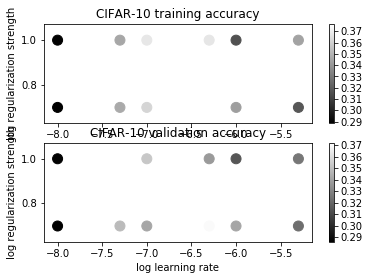

In [17]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [18]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.324000


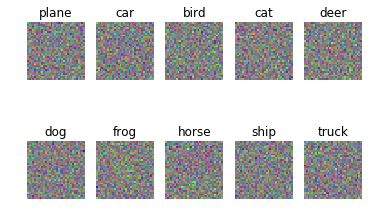

In [19]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *fill this in*